# 1. Setup

In [156]:
# TODO: clean this up
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as notebook_tqdm
import re
import string
import nltk
from nltk import pos_tag, download
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV




In [109]:
# Load the dataset from the Hugging Face Hub
notebook_tqdm.tqdm.pandas()
dataset = load_dataset('ucberkeley-dlab/measuring-hate-speech')

# Convert the dataset to a pandas DataFrame
df_raw = dataset['train'].to_pandas()

In [165]:
TRAIN_RATIO = 0.8 # TODO: factor this out everywhere
TEST_RATIO = 1 - TRAIN_RATIO
HATE_SPEECH_THRESHOLD_UNNORMALIZED = 0.5
SUPPORTIVE_THRESHOLD_UNNORMALIZED = -1
EVALUATION_METRICS = ['precision', 'recall', 'f1-score']


In [166]:
results = []

# 2. Filtering & EDA

### 2.0. Function definitions & variables

In [112]:
def plot_hate_speech_score_histogram(df: pd.DataFrame, hate_threshold: float, supportive_threshold: float):
    """
    Plots a histogram of the hate_speech_score with annotated lines at the thresholds

    Args:
        df (pd.DataFrame): The dataframe to plot the histogram from
        hate_threshold (float): The threshold for hate speech
        supportive_threshold (float): The threshold for supportive speech

    Returns:
        None (plots the histogram)
    """

    total_count = df.shape[0]
    
    # Calculate the amount of values below the supportive threshold
    supportive_count = df[df['hate_speech_score'] < supportive_threshold].shape[0]

    # Calculate the amount of values above the hate threshold
    hate_count = df[df['hate_speech_score'] > hate_threshold].shape[0]

    # Calculate the amount of values between the thresholds
    neutral_count = df[(df['hate_speech_score'] >= supportive_threshold) & (df['hate_speech_score'] <= hate_threshold)].shape[0]

    print(f"Total count: {total_count}")
    print(f"Supportive count: {supportive_count} ({supportive_count / total_count * 100:.2f}%)")
    print(f"Hate count: {hate_count} ({hate_count / total_count * 100:.2f}%)")
    print(f"Neutral count: {neutral_count} ({neutral_count / total_count * 100:.2f}%)")

    # Plot in histogram as well
    plt.hist(df['hate_speech_score'], bins=100)
    plt.axvline(hate_threshold, color='red', linestyle='--', label='Hate Speech Threshold')
    plt.axvline(supportive_threshold, color='blue', linestyle='--', label='Supportive Threshold')
    plt.legend()
    plt.show()

def plot_target_columns_distribution(df: pd.DataFrame, target_cols: list[str]):
    """
    Plots a barchart of the average value of the target columns for the hate speech observations

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distribution)
    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # Calculate the mean value of the target columns for the hate speech observations and sort them descending
    mean_values = hate_speech_df[target_cols].mean()
    mean_values = mean_values.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    mean_values.plot(kind='bar')
    plt.title('Percentage of hate speech columns targeting a specific group')
    plt.xlabel('Target Column')
    plt.ylabel('Percentage of hate speech')
    plt.show()

def plot_target_columns_detailed(df: pd.DataFrame, target_cols: list[str], fig_size: tuple[int, int] = (15, 30), y_max: float = 0.35):
    """
    Plots a bar chart for each of the target columns with detailed breakdowns of sub-groups

    Args:
        df (pd.DataFrame): The dataframe to plot the distribution from
        target_cols (list[str]): The columns to plot

    Returns:
        None (plots the distributions)

    """

    # Filter to count hate speech only
    hate_speech_df = df[df['is_hate_speech'] == 1]

    # initalize axes to plot the 7 sub-groups in two rows of 3 and a last row of 1
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=fig_size)
    # For each of the target columns, make a list of means of of hate speach targeting its sub-groups
    for ax, col in zip(axes.flatten(), target_cols):

        # Calculate the number of observations with a non-zero value for the target column
        non_zero_count = hate_speech_df[col].value_counts()[1]

        # identify all columns in the dataframe that starts with the target column name
        sub_groups_column_names = [column for column in df.columns if column.startswith(col)]

        # remove the original target column from the list
        sub_groups_column_names.remove(col)
        col_name = col.replace("target_", "").title()

        # calculate the mean values for each sub-group
        sub_group_means = hate_speech_df[sub_groups_column_names].mean()
        sub_group_means = sub_group_means.sort_values(ascending=False)

        # remove the col string from the labels
        labels = sub_group_means.index.str.replace((col + "_"), '')

        # plot on the specific axis
        sub_group_means.plot(kind='bar', ax=ax)
        ax.set_xticklabels(labels)
        ax.set_title(f'Percentage of hate speech targeting {col_name} by sub-group \n(n={non_zero_count})')
        ax.set_xlabel('Sub-group')
        ax.set_ylabel('Percentage of hate speech')
        ax.set_ylim(0, y_max)
    
    plt.subplots_adjust(hspace=0.7)

def inspect_for_cor(df, columns: list[str], plot_label: str, hate_speech_only: bool = True):

    # filter for hate speech only if specified
    if hate_speech_only:
        df = df[df['is_hate_speech'] == 1]
    
    # Make a correlation matrix
    corr_matrix = df[columns].corr()

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for {plot_label}')
    plt.show()

    # Make a pairplot of the columns
    sns.pairplot(df[columns])
    plt.title(f'Pairplot for {plot_label}')
    plt.show()


In [113]:
aspect_cols = [
    'insult',
    'humiliate',
    'status',
    'dehumanize',
    'violence',
    'genocide'
]

target_cols_lvl1_and_2 = [col for col in df_raw.columns if col.startswith('target_')]

target_cols_lvl1 = [
    'target_race',
    'target_religion',
    'target_origin',
    'target_gender',
    'target_sexuality',
    'target_age',
    'target_disability',    
]

cols_to_keep = [
    'comment_id', 
    'text', 
    'hate_speech_score',
    *aspect_cols,
    *target_cols_lvl1_and_2
]


### 2.1. Pre-filtering EDA

Total count: 135556
Supportive count: 53651 (39.58%)
Hate count: 49048 (36.18%)
Neutral count: 32857 (24.24%)


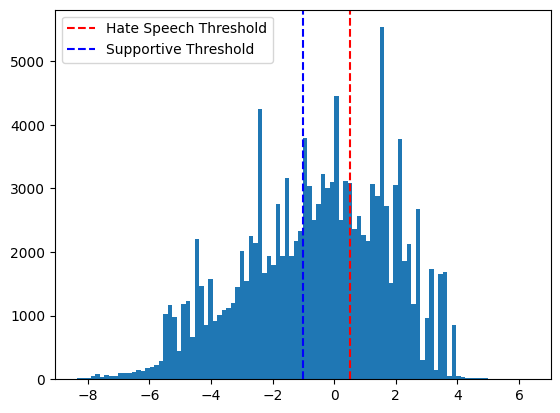

In [114]:
plot_hate_speech_score_histogram(df_raw, HATE_SPEECH_THRESHOLD_UNNORMALIZED, SUPPORTIVE_THRESHOLD_UNNORMALIZED)

### 2.2. Filtering & reformating

TODO: Make list of filtering actions for report 


In [115]:
# Check for duplicate rows based on the 'comment_id' column
duplicate_texts = df_raw[df_raw.duplicated(subset='comment_id', keep=False)]
print(f"Number of duplicate texts: {duplicate_texts.shape[0]}")
duplicate_texts[['comment_id', 'text']].head()

Number of duplicate texts: 125479


,comment_id,text
0,47777,"Yes indeed. She sort of reminds me of the elder lady that played the part in the movie ""Titanic"" who was telling her story!!! And I wouldn't have wanted to cover who I really am!! I would be proud!!!! WE should be proud of our race no matter what..."
1,39773,The trans women reading this tweet right now is beautiful
2,47101,"Question: These 4 broads who criticize America, what country did they flee to get here? And now they want to make OUR America like THEIR former HELL HOLE. I don't think so!!!!!!!!!! Let them explain their GRATITUDE for letting them in OUR country."
3,43625,It is about time for all illegals to go back to their country of origin and keep our freeway open and prevent heavy traffic.
4,12538,For starters bend over the one in pink and kick that ass and pussy to get a taste until she's begging for a dick inside her.


In [116]:
# Group by 'comment_id' and count unique 'hate_speech_score' values per group
score_check = df_raw.groupby("comment_id")["hate_speech_score"].nunique()

# Find texts with more than one unique score
inconsistent = score_check[score_check > 1]

# Show how many inconsistencies there are
print(f"Number of 'comment_id' entries with inconsistent scores: {len(inconsistent)}")

# Optionally, view a few examples
if not inconsistent.empty:
    print(df_raw[df_raw["comment_id"].isin(inconsistent.index)].sort_values("comment_id").head(10))

Number of 'comment_id' entries with inconsistent scores: 0


In [117]:
# Step 1: Select relevant columns
df_relevant = df_raw[cols_to_keep].copy()

# Step 2: Convert booleans to integers for mean calculation
bool_cols = [col for col in df_relevant.columns if col.startswith('target_')]
df_relevant[bool_cols] = df_relevant[bool_cols].astype(int)

# Step 3: Group by 'comment_id' and 'text' to keep them in final output
filtered_df = df_relevant.groupby(['comment_id', 'text']).mean().reset_index()

In [118]:
min_score = filtered_df['hate_speech_score'].min()  # e.g., -8.34
max_score = filtered_df['hate_speech_score'].max()  # e.g., +6.3

# replace hate speech core column with normalized column - [0, 1]
filtered_df['hate_speech_score'] = (filtered_df['hate_speech_score'] - min_score) / (max_score - min_score)


In [119]:
# Normalize the thresholds given by the dataset authors
HATE_SPEECH_THRESHOLD_NORMALIZED = (0.5 - min_score) / (max_score - min_score)  
SUPPORTIVE_THRESHOLD_NORMALIZED = (-1 - min_score) / (max_score - min_score)

# Add binary columns for hate speech
filtered_df.insert(filtered_df.columns.get_loc('hate_speech_score') + 1, 'is_hate_speech', (filtered_df['hate_speech_score'] > HATE_SPEECH_THRESHOLD_NORMALIZED).astype(int))

# Print new normalized thresholds 
print(f"Threshold for hate speech: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} on the original scale")
print(f"Threshold for counter speech: {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {-1} on the original scale")
print(f"Between the two thresholds: {HATE_SPEECH_THRESHOLD_NORMALIZED:.3f} and {SUPPORTIVE_THRESHOLD_NORMALIZED:.3f} -> Equivalent to {0.5} and {-1} on the original scale which is the unambiguous region")


Threshold for hate speech: 0.604 -> Equivalent to 0.5 on the original scale
Threshold for counter speech: 0.501 -> Equivalent to -1 on the original scale
Between the two thresholds: 0.604 and 0.501 -> Equivalent to 0.5 and -1 on the original scale which is the unambiguous region


In [120]:
filtered_df.describe()

,comment_id,hate_speech_score,is_hate_speech,insult,humiliate,status,dehumanize,violence,genocide,target_race_asian,...,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability
count,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,...,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000,39565.000000
mean,25064.175028,0.505197,0.261696,2.451707,2.170926,2.560852,1.700071,0.825427,0.448814,0.036070,...,0.001216,0.024744,0.002986,0.013872,0.006091,0.001186,0.001254,0.006339,0.002392,0.025676
std,14573.790336,0.141604,0.439563,1.185507,1.147433,0.699245,1.098025,1.000165,0.765847,0.161093,...,0.028330,0.137500,0.046627,0.105851,0.068472,0.029225,0.030446,0.068151,0.041602,0.146039
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12336.000000,0.410519,0.000000,1.666667,1.333333,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24986.000000,0.521858,0.000000,3.000000,2.333333,2.500000,1.666667,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37837.000000,0.608607,1.000000,3.333333,3.000000,3.000000,2.500000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50070.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [121]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   comment_id                             39565 non-null  int32  
 1   text                                   39565 non-null  object 
 2   hate_speech_score                      39565 non-null  float64
 3   is_hate_speech                         39565 non-null  int64  
 4   insult                                 39565 non-null  float64
 5   humiliate                              39565 non-null  float64
 6   status                                 39565 non-null  float64
 7   dehumanize                             39565 non-null  float64
 8   violence                               39565 non-null  float64
 9   genocide                               39565 non-null  float64
 10  target_race_asian                      39565 non-null  float64
 11  ta

### 2.3. Post-filtering EDA

Total count: 39565
Supportive count: 17475 (44.17%)
Hate count: 10354 (26.17%)
Neutral count: 11736 (29.66%)


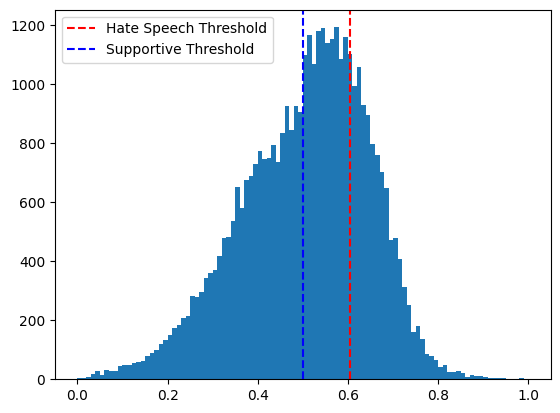

In [122]:
plot_hate_speech_score_histogram(filtered_df, HATE_SPEECH_THRESHOLD_NORMALIZED, SUPPORTIVE_THRESHOLD_NORMALIZED)

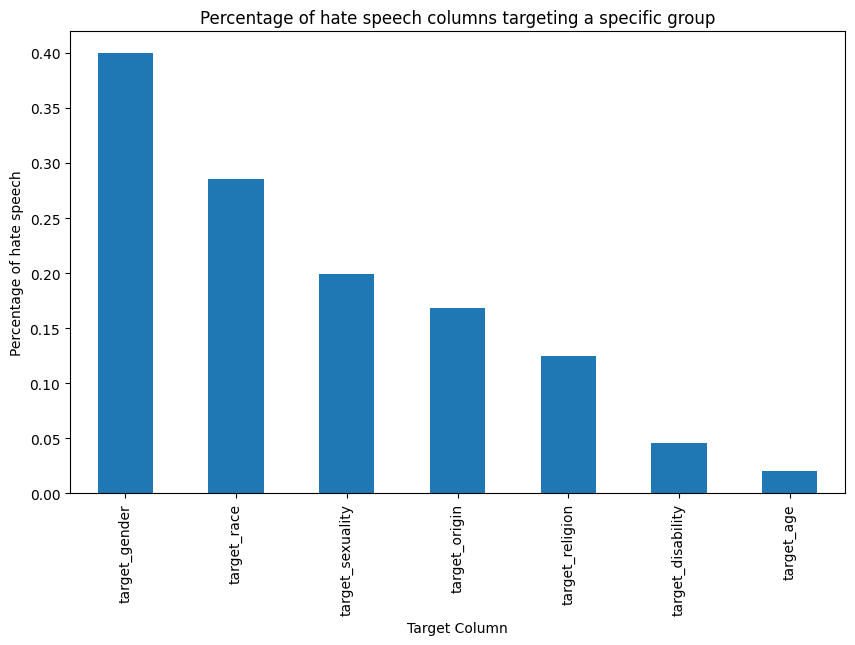

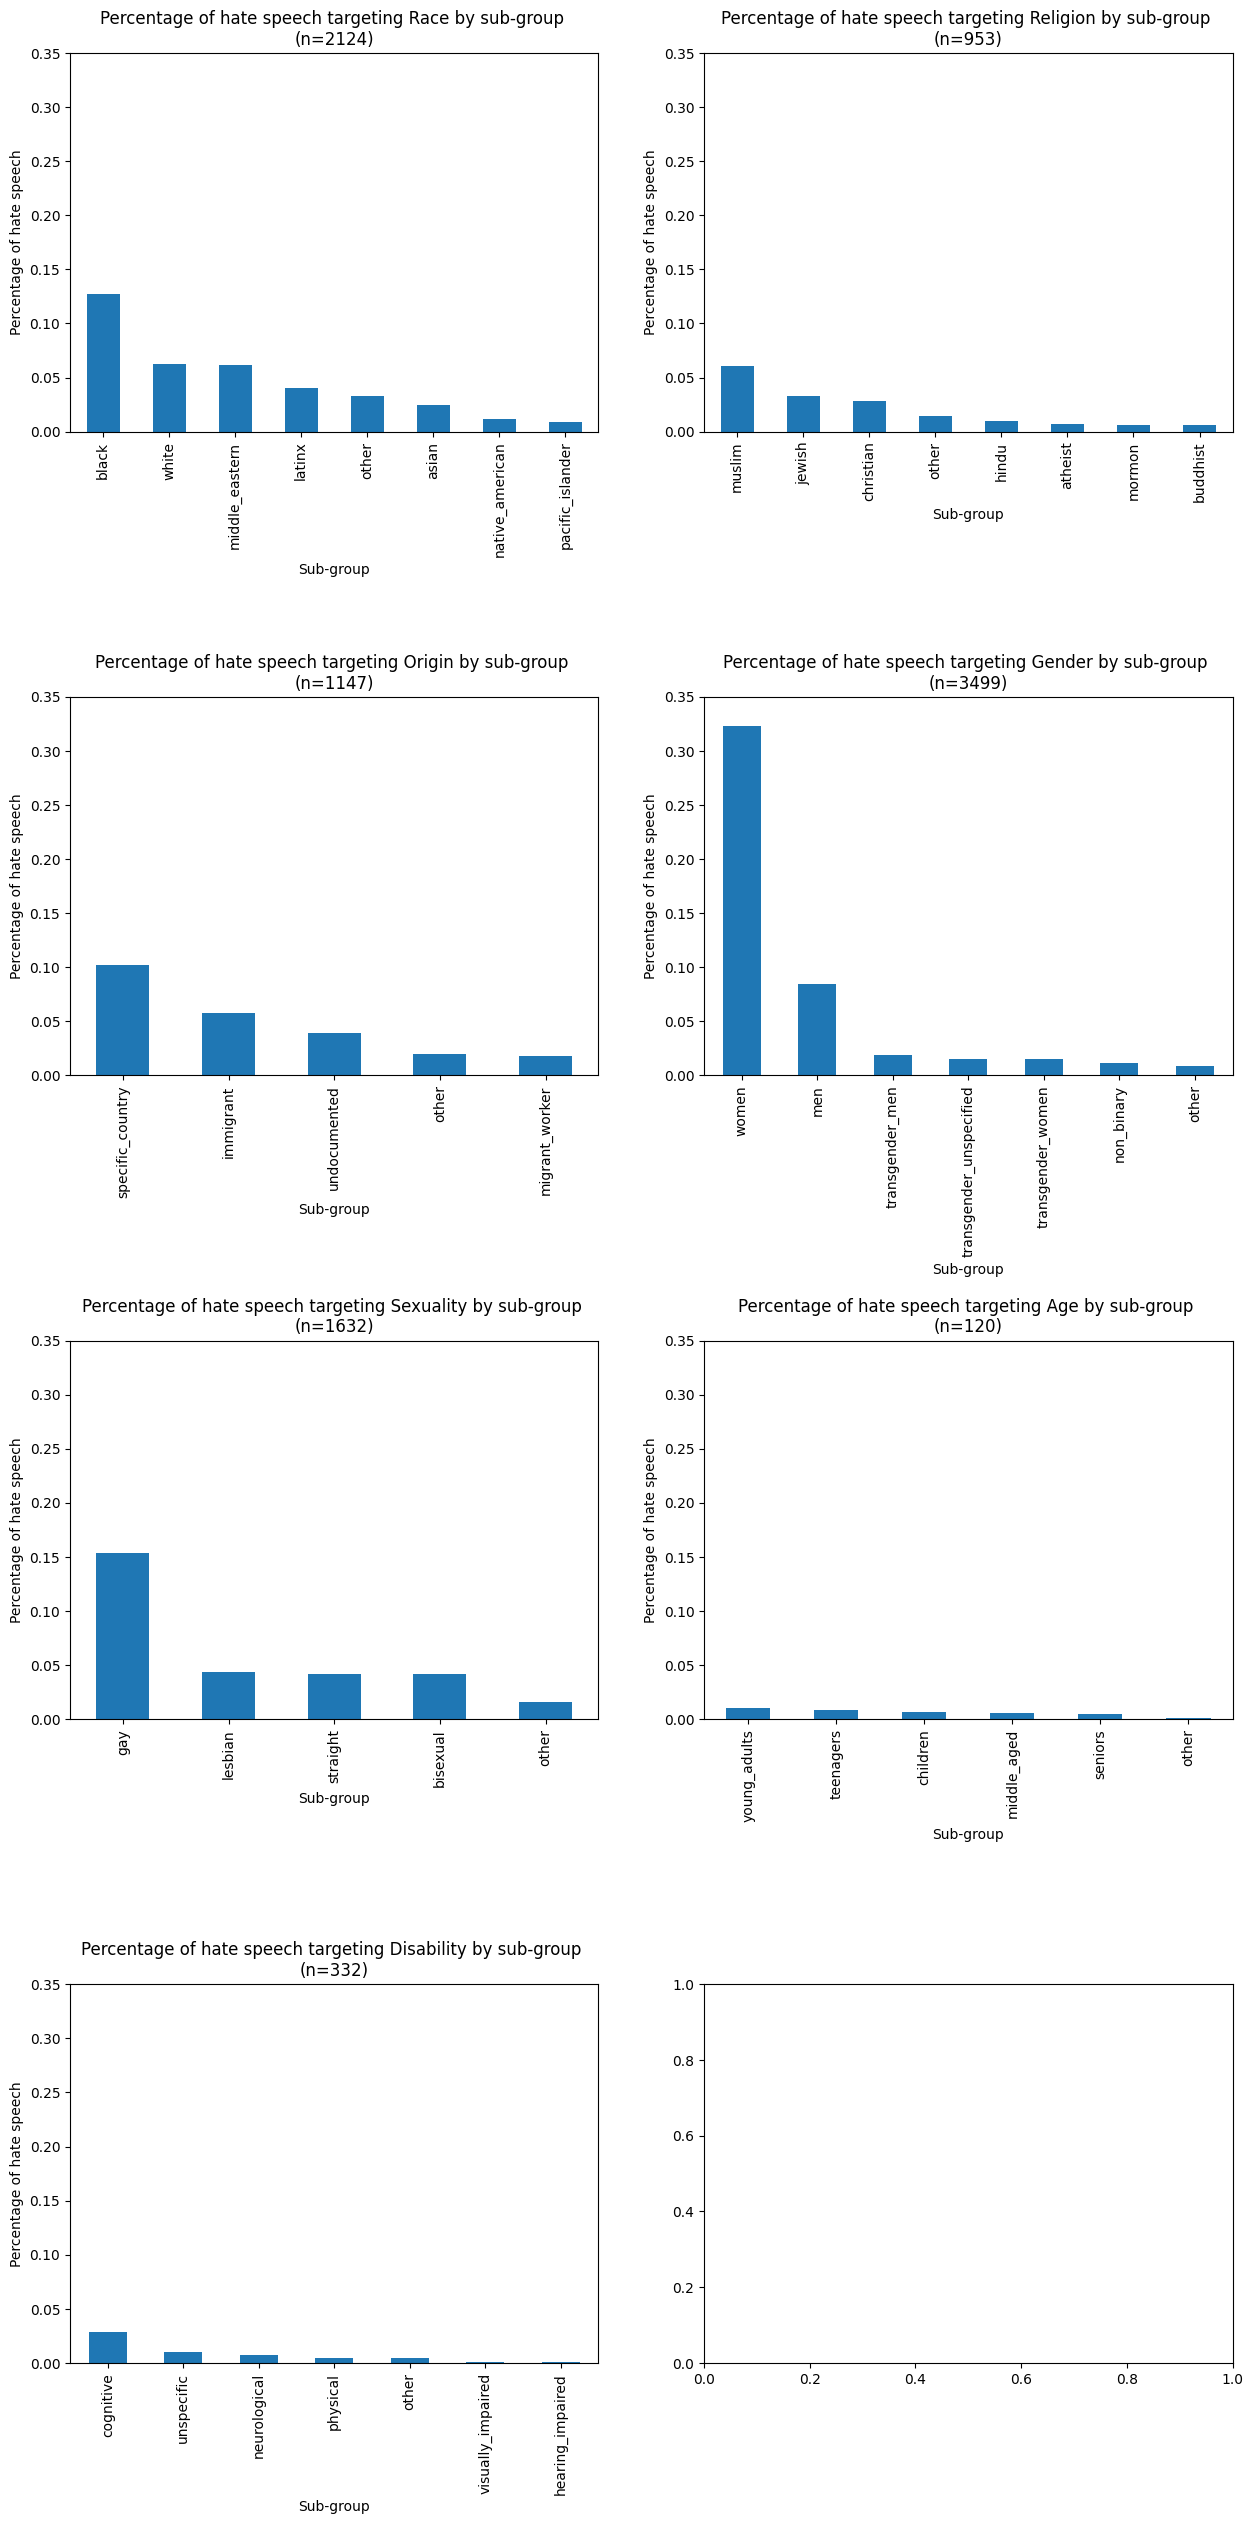

In [123]:
plot_target_columns_distribution(filtered_df, target_cols_lvl1)
plot_target_columns_detailed(filtered_df, target_cols_lvl1)

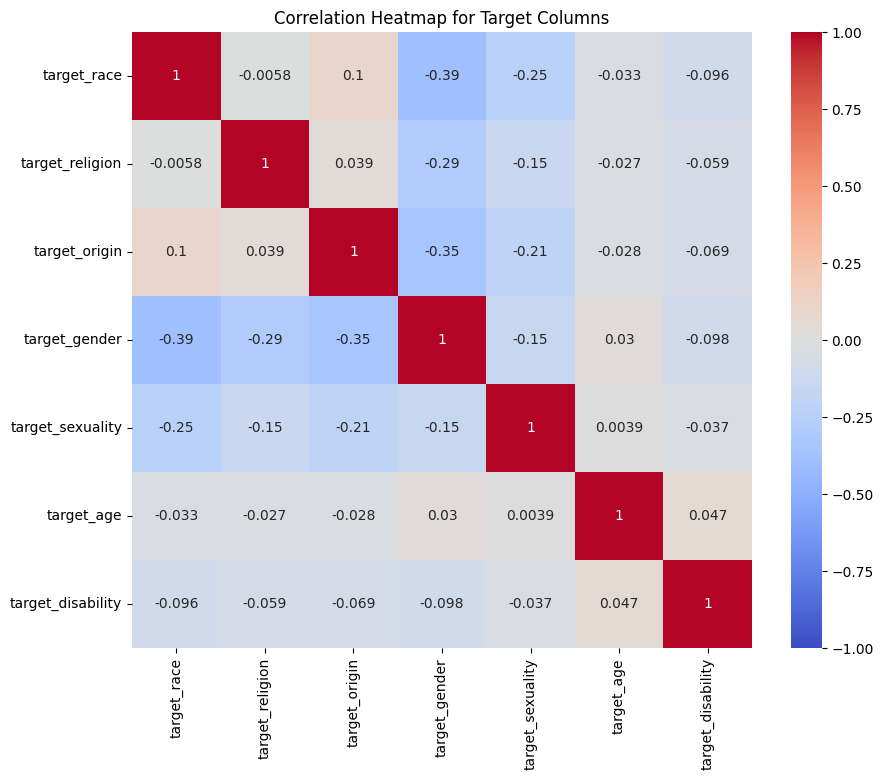

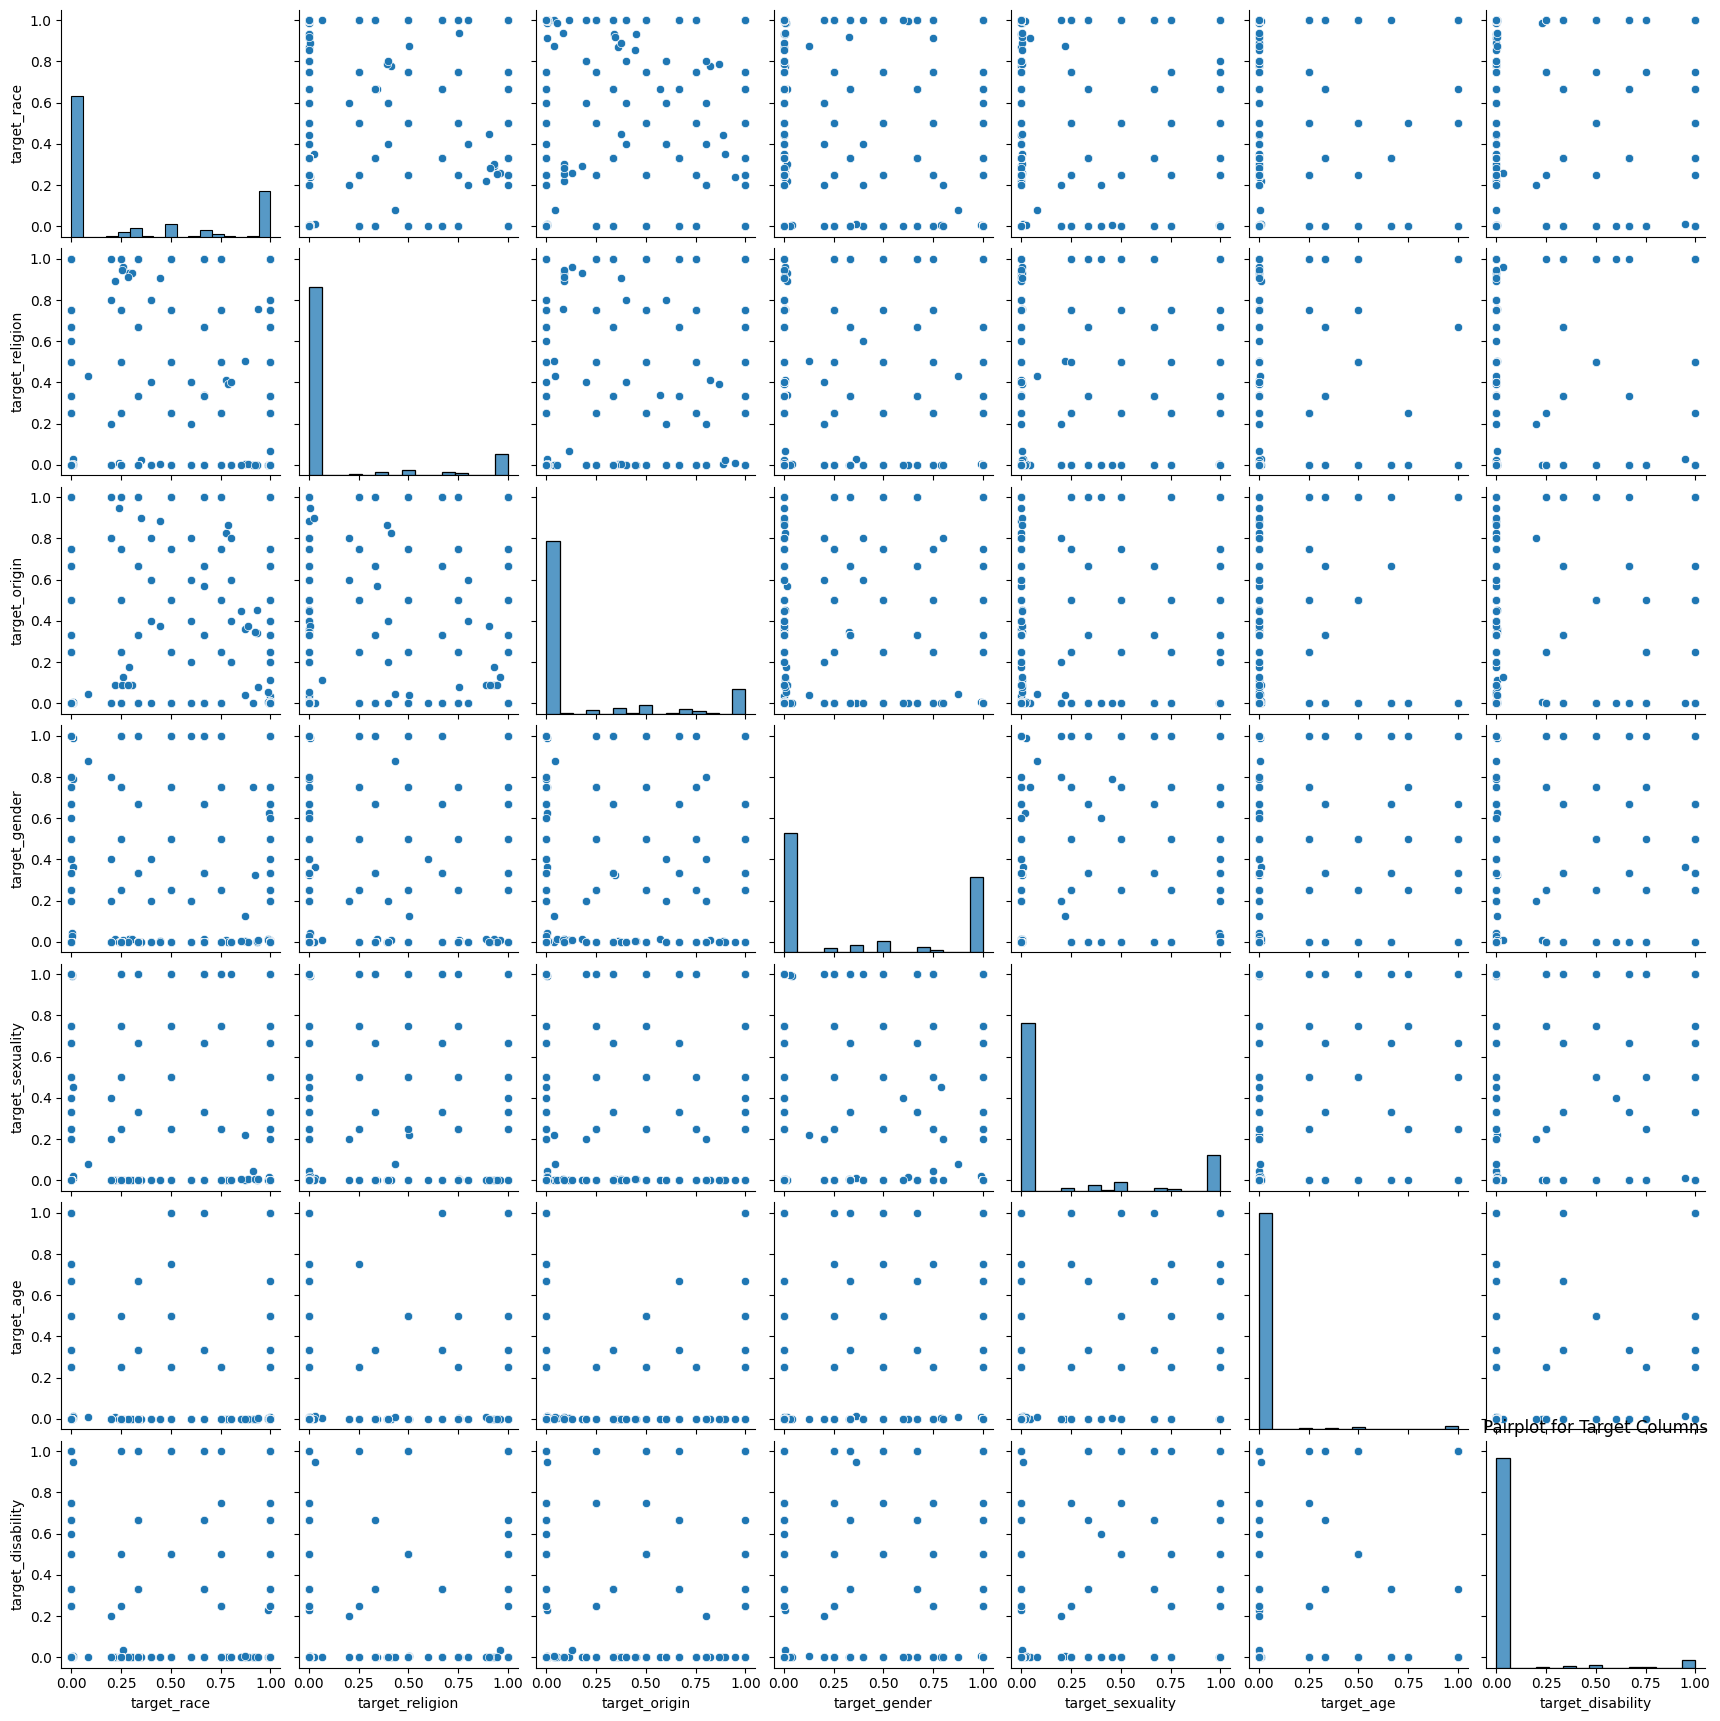

In [124]:
inspect_for_cor(filtered_df, target_cols_lvl1, 'Target Columns')

# 3. Models

### 3.0 Function & Class definitions

In [ ]:
def append_results(results: list, report: dict, model_name: str, metrics: list[str]):
    
    append_dict = {}

    for metric in metrics:
        append_dict[f'{metric}_hate'] = report['1'][metric]
        append_dict[f'{metric}_non_hate'] = report['0'][metric]
        append_dict[f'{metric}_macro_avg'] = report['macro avg'][metric]
        append_dict[f'{metric}_weighted_avg'] = report['weighted avg'][metric]

    append_dict['accuracy'] = report['accuracy']

    results.append({
        'model': model_name,
        **append_dict
    })


### 3.1. BoW + Logistic Regression

In [125]:
# Dataframe for Bag of Words (BoW) representation
bow_df = filtered_df.copy()

# Releveant columns
bow_cols = ['text', 'is_hate_speech']

# Select relevant columns
bow_df = bow_df[bow_cols]


In [126]:
label_counts = bow_df['is_hate_speech'].value_counts()
label_percentage = bow_df['is_hate_speech'].value_counts(normalize=True) * 100

print("Label Counts:")
print(label_counts)
print("\nLabel Percentage Distribution:")
print(label_percentage)

Label Counts:
is_hate_speech
0    29211
1    10354
Name: count, dtype: int64

Label Percentage Distribution:
is_hate_speech
0    73.830406
1    26.169594
Name: proportion, dtype: float64


##### 3.1.1 Data preprocessing

TODO: Maybe remove preprocessing from pipepine to just have it done once for "Part 2" of Assignment 3 approach

In [144]:
# Download necessary NLTK resources
for resource in ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

# Tokenizer
tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """
    Convert the part of speech tag to a format that WordNet lemmatizer can understand.
    starts with 'J' for adjectives, 'V' for verbs, 'N' for nouns, and 'R' for adverbs.
    Args:
        tag (str): The part of speech tag.
    Returns:
        str: The WordNet part of speech tag.
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def is_ascii(token):
    return all(ord(c) < 128 for c in token)

def remove_repeated_chars(token, threshold=3):
    return re.sub(r'(.)\1{' + str(threshold) + r',}', r'\1', token)

def bow_preprocess(text):
    """
    Preprocess the text by tokenizing, removing punctuation, stop words,
    and lemmatizing the words.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    Example:
        >>> preprocess("This is an EXAMPLE sentence!!!.")
        'example sentence'
        
    """
    tokens = tknzr.tokenize(text) # Tokenize the text
    tokens = [word.lower() for word in tokens if word not in string.punctuation] # Remove punctuation
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    tokens = [remove_repeated_chars(word) for word in tokens] # Remove repeated characters, ex: "loooove" -> "love"
    tokens = [word for word in tokens if len(word) >= 2 and is_ascii(word)]  # Filter by length and ASCII
    pos_tags = pos_tag(tokens) # Get part of speech tags
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags] # Lemmatize the words using the part of speech tags
    return " ".join(lemmatized)

In [145]:
class BOWTextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.progress_apply(bow_preprocess)

In [146]:
bow_pipeline = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [147]:
X = bow_df['text']
y = bow_df['is_hate_speech']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=42)


##### 3.1.2. Fit model to training set - BoW + LogReg

In [148]:
# Fit the pipeline to the training data
bow_pipeline.fit(X_train, y_train)


100%|██████████| 31652/31652 [00:13<00:00, 2395.99it/s]


Pipeline(steps=[('preprocessor', BOWTextPreprocessor()),
                ('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [150]:
# Make predictions on the test set
y_pred_bow = bow_pipeline.predict(X_test)

# Generate the classification report
report_bow = classification_report(y_test, y_pred_bow, output_dict=True)

100%|██████████| 7913/7913 [00:03<00:00, 2242.69it/s]


In [152]:
results = []
results.append({
    'model': 'BoW + LogisticRegression',
    'precision_hate': report_bow['1']['precision'],
    'recall_hate': report_bow['1']['recall'],
    'f1_hate': report_bow['1']['f1-score'],
    'accuracy': report_bow['accuracy']
})

### 3.2 TF-IDF + Logistic Regression

In [154]:
pipeline_tfidf = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

pipeline_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipeline_tfidf.predict(X_test)

report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)

100%|██████████| 7913/7913 [00:03<00:00, 2553.30it/s]


In [155]:
results.append({
    'model': 'TF-IDF + LogisticRegression',
    'precision_hate': report_tfidf['1']['precision'],
    'recall_hate': report_tfidf['1']['recall'],
    'f1_hate': report_tfidf['1']['f1-score'],
    'accuracy': report_tfidf['accuracy']
})

##### 3.2.2 Hyperparameter tuning with GridSearchCV

In [158]:
pipeline_tuned = Pipeline([
    ('preprocessor', BOWTextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),  # or CountVectorizer()
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

param_grid = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_features': [5000, 10000],
    'vectorizer__max_df': [0.75, 0.9],
    'classifier__C': [0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # Needed to compare L1 and L2
}

grid_search = GridSearchCV(
    pipeline_tuned,
    param_grid,
    cv=3, 
    scoring='f1', 
    verbose=2, 
    n_jobs=1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


  0%|          | 0/21101 [00:00<?, ?it/s]

100%|██████████| 10551/10551 [00:04<00:00, 2631.82it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.6s


100%|██████████| 10551/10551 [00:03<00:00, 2642.53it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.1s


100%|██████████| 10550/10550 [00:03<00:00, 2660.79it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.1s


100%|██████████| 10551/10551 [00:03<00:00, 2646.86it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2626.26it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10550/10550 [00:03<00:00, 2652.33it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:03<00:00, 2643.17it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2618.45it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:03<00:00, 2639.91it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2622.62it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2615.90it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:03<00:00, 2656.56it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2635.62it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2624.30it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:03<00:00, 2652.72it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:03<00:00, 2641.58it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2581.61it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.7s


100%|██████████| 10550/10550 [00:03<00:00, 2651.61it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2597.54it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10551/10551 [00:04<00:00, 2619.61it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.4s


100%|██████████| 10550/10550 [00:04<00:00, 2633.84it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2606.33it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.7s


100%|██████████| 10551/10551 [00:03<00:00, 2638.75it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10550/10550 [00:03<00:00, 2650.02it/s]


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:03<00:00, 2639.51it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10551/10551 [00:04<00:00, 2609.23it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10550/10550 [00:04<00:00, 2636.79it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10551/10551 [00:04<00:00, 2622.00it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2627.44it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10550/10550 [00:03<00:00, 2639.55it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2568.44it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10551/10551 [00:04<00:00, 2594.42it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10550/10550 [00:04<00:00, 2620.41it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10551/10551 [00:04<00:00, 2608.66it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2602.98it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:04<00:00, 2615.62it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2625.73it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2627.91it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:03<00:00, 2653.95it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:03<00:00, 2640.73it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2609.58it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:03<00:00, 2643.27it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2615.85it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2607.58it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:04<00:00, 2626.90it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.4s


100%|██████████| 10551/10551 [00:04<00:00, 2606.73it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2605.80it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:03<00:00, 2640.38it/s]


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2619.33it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10551/10551 [00:04<00:00, 2631.06it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:03<00:00, 2664.14it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:03<00:00, 2642.56it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2633.72it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10550/10550 [00:03<00:00, 2643.13it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2633.64it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2623.79it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:03<00:00, 2653.58it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:03<00:00, 2652.66it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2636.30it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10550/10550 [00:03<00:00, 2652.72it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2626.41it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2616.24it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:03<00:00, 2647.17it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2625.78it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2629.21it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:03<00:00, 2654.11it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:03<00:00, 2640.03it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2622.29it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:03<00:00, 2644.63it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2635.04it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2621.08it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:03<00:00, 2660.65it/s]


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2618.85it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10551/10551 [00:04<00:00, 2615.53it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:03<00:00, 2658.86it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:03<00:00, 2639.66it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2616.02it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:03<00:00, 2655.25it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2615.92it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10551/10551 [00:04<00:00, 2592.44it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:04<00:00, 2627.97it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2603.75it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2595.18it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:04<00:00, 2633.93it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.75, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.5s


100%|██████████| 10551/10551 [00:04<00:00, 2557.61it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.4s


100%|██████████| 10551/10551 [00:04<00:00, 2634.11it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10550/10550 [00:03<00:00, 2655.50it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 1); total time=  12.2s


100%|██████████| 10551/10551 [00:04<00:00, 2634.95it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2610.15it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:03<00:00, 2641.63it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=5000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10551/10551 [00:04<00:00, 2608.14it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10551/10551 [00:04<00:00, 2596.35it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.3s


100%|██████████| 10550/10550 [00:04<00:00, 2632.96it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 1); total time=  12.4s


100%|██████████| 10551/10551 [00:04<00:00, 2587.88it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.7s


100%|██████████| 10551/10551 [00:04<00:00, 2613.98it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.6s


100%|██████████| 10550/10550 [00:04<00:00, 2589.73it/s]


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear, vectorizer__max_df=0.9, vectorizer__max_features=10000, vectorizer__ngram_range=(1, 2); total time=  12.7s


100%|██████████| 31652/31652 [00:12<00:00, 2625.93it/s]


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor', BOWTextPreprocessor()),
                                       ('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=1,
             param_grid={'classifier__C': [0.1, 1],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear'],
                         'vectorizer__max_df': [0.75, 0.9],
                         'vectorizer__max_features': [5000, 10000],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=2)

In [163]:

print("Best params:", grid_search.best_params_)
print("Best cross-validated F1 score:", grid_search.best_score_)

# Use best model to predict test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)

append_results(results, report_tuned, 'Tuned BoW + LogisticRegression', EVALUATION_METRICS)



Best params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}
Best cross-validated F1 score: 0.6257638236310815


100%|██████████| 7913/7913 [00:03<00:00, 2614.28it/s]


# 4. Evaluation

In [164]:
results_df = pd.DataFrame(results)

results_df

,model,precision_hate,recall_hate,f1_hate,accuracy,precision_non_hate,precision_macro_avg,precision_weighted_avg,recall_non_hate,recall_macro_avg,recall_weighted_avg,f1-score_hate,f1-score_non_hate,f1-score_macro_avg,f1-score_weighted_avg
0,BoW + LogisticRegression,0.555950,0.683624,0.613212,0.775054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TF-IDF + LogisticRegression,0.551529,0.707849,0.619987,0.773664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tuned BoW + LogisticRegression,0.548785,0.711240,NaN,0.772147,0.886216,0.717501,0.798202,0.79364,0.75244,0.772147,0.61954,0.837377,0.728459,0.780557
